In [1]:
!pip install geojson_utils

In [50]:
import pandas as pd
import numpy as np
import folium
import requests
import geojson_utils
from sklearn.cluster import KMeans

import seaborn as sns
sns.set()

# Restaurant diversity in Boston neighborhoods

In this notebook, we use the Foursquare API to explore restaurants in the neighborhoods of Boston and classify the neighborhoods based on the diversity of their cuisine options.

## Geographical data for Boston neighborhoods

The geographical coordinates for the neighborhoods in Boston are available from the City of Boston: https://data.boston.gov/dataset/boston-neighborhoods. We will load this into the variable `geodata`.

In [2]:
url = 'http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.geojson'
geodata = requests.get(url).json()
geodata

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'OBJECTID': 27,
    'Name': 'Roslindale',
    'Acres': 1605.5682375,
    'Neighborhood_ID': '15',
    'SqMiles': 2.51,
    'ShapeSTArea': 69938272.92557049,
    'ShapeSTLength': 53563.912597056624},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-71.12592717485386, 42.272013107957406],
       [-71.12610933458738, 42.2716219294518],
       [-71.12603188298199, 42.27158985153841],
       [-71.12571713956957, 42.27152070474045],
       [-71.12559042372907, 42.27146017841939],
       [-71.12523676125656, 42.271387313901805],
       [-71.12522437821433, 42.271425073651166],
       [-71.12489533053173, 42.27134458090032],
       [-71.12482468090687, 42.271318140479686],
       [-71.12485155056099, 42.27124753819149],
       [-71.12476329046935, 42.270292339717635],
       [-71.12470249712558, 42.270295367758344],
       [-71.12259088359436, 42.2700534081311],
       [-71.1223931813923, 42.270030

`geodata['features']` is a list of dictionaries with information for each neighborhood. We will create a dataframe to store the neighborhood name and geographical coordinates.

The coordinates are given as either a `Polygon` or `MultiPolygon` boundary. `MultiPolygon` coordinates are given as a list of polygons, so the list in total is four layers deep, while `Polygon` coordinates are in a list only three layers deep. To account for this, we add a layer of nesting in the `Polygon` coordinate lists.

We will also store the `Polygon` objects in the dataframe for use with `geojson_utils`, a package that we will use to determine whether a venue falls within the boundaries of a given neighborhood.

In [3]:
df = pd.DataFrame(columns=['neighborhood', 'coordinates'])

for f in geodata['features']:
    coords = f['geometry']['coordinates']
    if f['geometry']['type'] == 'Polygon':
        coords = [coords]
    
    df = df.append({'neighborhood': f['properties']['Name'],
                    'coordinates': coords,
                    'polygon': f['geometry']
                   },
                   ignore_index=True)

In [4]:
df.head()

neighborhood                                        coordinates  \
0     Roslindale  [[[[-71.12592717485386, 42.272013107957406], [...   
1  Jamaica Plain  [[[[-71.10499218689807, 42.326101682808066], [...   
2   Mission Hill  [[[[-71.0904343142608, 42.33576996328494], [-7...   
3       Longwood  [[[[-71.09810894210769, 42.33673037764089], [-...   
4    Bay Village  [[[[-71.06662924918761, 42.34878268384542], [-...   

                                             polygon  
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...  
1  {'type': 'Polygon', 'coordinates': [[[-71.1049...  
2  {'type': 'Polygon', 'coordinates': [[[-71.0904...  
3  {'type': 'Polygon', 'coordinates': [[[-71.0981...  
4  {'type': 'Polygon', 'coordinates': [[[-71.0666...

We should also find the geographical centers of the neighborhoods, and while we're at it, let's store the geographical area of each neighborhood. We will find these using the below `centroid_area` function (adapted from the `geojson_utils` package).

In [5]:
def centroid_area(coords):
    f_total = 0
    x_total = 0
    y_total = 0
    poly_area = 0

    j = len(coords) - 1
    count = len(coords)

    for i in range(0, count):
        p1_x = coords[i][1]
        p1_y = coords[i][0]
        p2_x = coords[j][1]
        p2_y = coords[j][0]


        f_total = p1_x * p2_y - p2_x * p1_y
        x_total += (p1_x + p2_x) * f_total
        y_total += (p1_y + p2_y) * f_total
        
        poly_area += p1_x * p2_y
        poly_area -= p1_y * p2_x
        j = i
                    
    six_area = poly_area / 2 * 6
    return np.array([y_total / six_area, x_total / six_area]), six_area

To get down to the [longitude, latitude] coordinates, we will have to loop through the outer two list layers. Let's create a new list of coordinates for each neighborhood containing the full list of boundary points (but ignoring the separation of polygons). We then find the centroid and area of these coordinates and store the results in the dataframe.

In [6]:
df['center'] = ''
df['area'] = ''

for i, c in enumerate(df['coordinates']):
    lng_min, lng_max, lat_min, lat_max = 0, -1000, 1000, 0
    
    coords = []
    count = 0
    for j in range(len(c)):
        for k in range(len(c[j])):
            coords.append(np.array(c[j][k])) # collect boundaries for each polygon in the neighborhood
            
    coords = np.concatenate(coords) # make one array of boundary points for the neighborhood
    df['center'][i], df['area'][i] = centroid_area(coords)

In [7]:
df.head()

neighborhood                                        coordinates  \
0     Roslindale  [[[[-71.12592717485386, 42.272013107957406], [...   
1  Jamaica Plain  [[[[-71.10499218689807, 42.326101682808066], [...   
2   Mission Hill  [[[[-71.0904343142608, 42.33576996328494], [-7...   
3       Longwood  [[[[-71.09810894210769, 42.33673037764089], [-...   
4    Bay Village  [[[[-71.06662924918761, 42.34878268384542], [-...   

                                             polygon  \
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   
1  {'type': 'Polygon', 'coordinates': [[[-71.1049...   
2  {'type': 'Polygon', 'coordinates': [[[-71.0904...   
3  {'type': 'Polygon', 'coordinates': [[[-71.0981...   
4  {'type': 'Polygon', 'coordinates': [[[-71.0666...   

                                     center         area  
0  [-71.12666256565596, 42.282523940356576]    0.0042553  
1   [-71.11509687004941, 42.30776945995205]   0.00667949  
2  [-71.10260671077644, 42.331741522957486]  0.000930596  
3    [-71.1051033165732, 42.33860925968864]  0.000500324  
4   [-71.06903126349887, 42.34910280642528]  7.04128e-05

## Visualizing neighborhoods

Let's visualize the neighborhoods with a map. To find the geographical center, let's find the average latitude/longitude.

In [8]:
# find average latitude/longitude
lng_avg, lat_avg = df['center'].mean()

In [9]:
m = folium.Map(location=[lat_avg, lng_avg], zoom_start=12)

folium.GeoJson(geodata).add_to(m)

# loop over neighborhoods
for i in range(df.shape[0]):
    s = df['neighborhood'][i]
    label = folium.Popup(s)

    folium.CircleMarker(
        df['center'][i][::-1],
        radius=4,
        color='black',
        fill_color='white',
        fill_opacity=0.5,
        popup=label).add_to(m)  
   
m

The neighborhoods are all clearly different sizes, so we should account for the different areas when using the Foursquare API. Let's use the area we extracted from the polygon coordinates to vizualize the search radius. We use a scaling factor to convert the area (in terms of latitude/longitude) to a physical radius.

In [10]:
m = folium.Map(location=[lat_avg, lng_avg], zoom_start=12)

folium.GeoJson(geodata).add_to(m)

df['radius'] = ''

# loop over neighborhoods
for i in range(df.shape[0]):
    s = df['neighborhood'][i]
    label = folium.Popup(s)
    
    RADIUS = np.sqrt(df['area'][i]) * 20000 # convert to a radius and scale
    df['radius'][i] = RADIUS
    
    folium.Circle(
        df['center'][i][::-1],
        radius=RADIUS, # radius in meters,
        fill_color='black',
        color='black'
    ).add_to(m)
   
m

The search areas overlap minimally while still encompassing most of each neighborhood. The scale factor we chose gives an appropriate search radius. We added the radius to the dataframe, so let's examine it once again.

In [11]:
df.head()

neighborhood                                        coordinates  \
0     Roslindale  [[[[-71.12592717485386, 42.272013107957406], [...   
1  Jamaica Plain  [[[[-71.10499218689807, 42.326101682808066], [...   
2   Mission Hill  [[[[-71.0904343142608, 42.33576996328494], [-7...   
3       Longwood  [[[[-71.09810894210769, 42.33673037764089], [-...   
4    Bay Village  [[[[-71.06662924918761, 42.34878268384542], [-...   

                                             polygon  \
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   
1  {'type': 'Polygon', 'coordinates': [[[-71.1049...   
2  {'type': 'Polygon', 'coordinates': [[[-71.0904...   
3  {'type': 'Polygon', 'coordinates': [[[-71.0981...   
4  {'type': 'Polygon', 'coordinates': [[[-71.0666...   

                                     center         area   radius  
0  [-71.12666256565596, 42.282523940356576]    0.0042553  1304.65  
1   [-71.11509687004941, 42.30776945995205]   0.00667949  1634.56  
2  [-71.10260671077644, 42.331741522957486]  0.000930596  610.114  
3    [-71.1051033165732, 42.33860925968864]  0.000500324  447.358  
4   [-71.06903126349887, 42.34910280642528]  7.04128e-05  167.825

## Exploring restaurants in neighborhoods

### Test the API call

We will now use the Foursquare API to explore these neighborhoods. Below is the information needed to make requests to the API.

In [12]:
CLIENT_ID = 'ESQILQUJ45MEFP5CYAUTQAPRNT1YA22FASZDU0VCI5VIE2EP'
CLIENT_SECRET = 'MZIKSDQUL4OHRIPALRKSUQSKUMMVKM2PCGAMGJPWKJ3G0MBZ'
VERSION = '20200415' # Foursquare API version
LIMIT = 100

Let's start by searching for restaurants in the first neighborhood, and then we will loop over neighborhoods once we have confirmed the API call and data cleaning code is working properly. 

To search for restaurants, we will pass the [`categoryId`](https://developer.foursquare.com/docs/build-with-foursquare/categories/) for "Food" (4d4b7105d754a06374d81259) to the API call.


In [13]:
i = 1
lng, lat = df['center'][i]
radius = df['radius'][i]

url = 'https://api.foursquare.com/v2/venues/search?\
                    &client_id={}\
                    &client_secret={}\
                    &v={}\
                    &ll={},{}\
                    &radius={}\
                    &limit={}\
                    &categoryId=4d4b7105d754a06374d81259'.format(
                        CLIENT_ID, 
                        CLIENT_SECRET, 
                        VERSION, 
                        lat, 
                        lng, 
                        radius, 
                        LIMIT)
venues = requests.get(url).json()['response']['venues']
venues

[{'id': '5e459a8a70758c00083c0a60',
  'name': 'Monumental Market',
  'location': {'address': '36 South St',
   'lat': 42.308392,
   'lng': -71.115387,
   'labeledLatLngs': [{'label': 'display',
     'lat': 42.308392,
     'lng': -71.115387},
    {'label': 'entrance', 'lat': 42.308364, 'lng': -71.115443}],
   'distance': 73,
   'postalCode': '02130',
   'cc': 'US',
   'city': 'Boston',
   'state': 'MA',
   'country': 'United States',
   'formattedAddress': ['36 South St', 'Boston, MA 02130', 'United States']},
  'categories': [{'id': '4bf58dd8d48988d1e0931735',
    'name': 'Coffee Shop',
    'pluralName': 'Coffee Shops',
    'shortName': 'Coffee Shop',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1587095831',
  'hasPerk': False},
 {'id': '53d17433498eafbef90481e4',
  'name': "Domino's Pizza",
  'location': {'address': '4000 Washington St',
   'lat': 42.29232216591031,
   'lng': -71.121

Because our search areas overlap, we should only keep restaurants that belong to the intended neighborhood. We again employ the `geojson_utils` package, this time calling the `_point_in_polygon` function directly to check if the coordinates of each restaurant fall inside the neighborhood boundary stored in `df['polygon']`.

In [14]:
lat_not_in_polygon, lng_not_in_polygon, name_not_in_polygon = [], [], [] # to store info for venues outside boundary

for v in venues:
    lat, lng = v['location']['lat'], v['location']['lng']
    point = {'coordinates': [lng, lat]}
    if not geojson_utils.point_in_polygon(point, df['polygon'][i]):
        lat_not_in_polygon.append(lat)
        lng_not_in_polygon.append(lng)
        name_not_in_polygon.append(v['name'])
        print(name_not_in_polygon[-1])

Domino's Pizza
McDonald's


We see that it is possible for venues to fall outside the neighborhood boundary. Let's visualize this on the map.

In [15]:
m = folium.Map(location=df['center'][i][::-1], zoom_start=13.5)

# geodata = geodata[geo]
folium.GeoJson(df['polygon'][i]).add_to(m)

s = df['neighborhood'][i]
label = folium.Popup(s)

RADIUS = np.sqrt(df['area'][i]) * 20000 # convert to a radius and scale
df['radius'][i] = RADIUS

folium.Circle(
    df['center'][i][::-1],
    radius=RADIUS, # radius in meters,
    fill_color='black',
    color='black'
).add_to(m)

# Plot the outsider restaurants as reds point
for lat, lng in zip(lat_not_in_polygon, lng_not_in_polygon):
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        fill_color='red',
        color='red'
    ).add_to(m)

# Plot the other venues as green points
for v in venues:
    if v['name'] not in name_not_in_polygon:
        folium.CircleMarker(
        [v['location']['lat'], v['location']['lng']],
        radius=4,
        fill_color='green',
        color='green'
        ).add_to(m)
   
m

First we note that there are venues that lie outside the search radius (probably because of a discrepancy between the definition of the `radius` parameter for Foursquare vs. Folium). Two of these venues (red) also lie outside the neighborhood boundary (blue). We will discard these venues, because they will probably get identified by the search centered in the correct neighborhood.

### Loop over neighborhoods and call API

Now we can loop over the neighborhoods to obtain venue information. Let's store the API responses in a new column in the dataframe.

In [16]:
df['venues'] = ''

for i in range(df.shape[0]):

    print(df['neighborhood'][i])
    lng, lat = df['center'][i]
    radius = df['radius'][i]

    url = 'https://api.foursquare.com/v2/venues/search?\
                    &client_id={}\
                    &client_secret={}\
                    &v={}\
                    &ll={},{}\
                    &radius={}\
                    &limit={}\
                    &categoryId=4d4b7105d754a06374d81259'.format(
                        CLIENT_ID, 
                        CLIENT_SECRET, 
                        VERSION, 
                        lat, 
                        lng, 
                        radius, 
                        LIMIT)
    venues = requests.get(url).json()['response']['venues']
    
    # Remove venues that are not within the neighborhood boundary
    venues2 = [] # store valid venues in this list
    for v in venues:
        lat, lng = v['location']['lat'], v['location']['lng']
        point = {'coordinates': [lng, lat]}
        if geojson_utils.point_in_polygon(point, df['polygon'][i]): # keep venues within boundary
            venues2.append(v)
        
    
    df['venues'][i] = venues2

Roslindale
Jamaica Plain
Mission Hill
Longwood
Bay Village
Leather District
Chinatown
North End
Roxbury
South End
Back Bay
East Boston
Charlestown
West End
Beacon Hill
Downtown
Fenway
Brighton
West Roxbury
Hyde Park
Mattapan
Dorchester
South Boston Waterfront
South Boston
Allston
Harbor Islands


The unprocessed API calls are stored in the dataframe `'venues'` column. We store this here temporarily so we won't have to call the API again.

In [17]:
df.head()

neighborhood                                        coordinates  \
0     Roslindale  [[[[-71.12592717485386, 42.272013107957406], [...   
1  Jamaica Plain  [[[[-71.10499218689807, 42.326101682808066], [...   
2   Mission Hill  [[[[-71.0904343142608, 42.33576996328494], [-7...   
3       Longwood  [[[[-71.09810894210769, 42.33673037764089], [-...   
4    Bay Village  [[[[-71.06662924918761, 42.34878268384542], [-...   

                                             polygon  \
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   
1  {'type': 'Polygon', 'coordinates': [[[-71.1049...   
2  {'type': 'Polygon', 'coordinates': [[[-71.0904...   
3  {'type': 'Polygon', 'coordinates': [[[-71.0981...   
4  {'type': 'Polygon', 'coordinates': [[[-71.0666...   

                                     center         area   radius  \
0  [-71.12666256565596, 42.282523940356576]    0.0042553  1304.65   
1   [-71.11509687004941, 42.30776945995205]   0.00667949  1634.56   
2  [-71.10260671077644, 42.331741522957486]  0.000930596  610.114   
3    [-71.1051033165732, 42.33860925968864]  0.000500324  447.358   
4   [-71.06903126349887, 42.34910280642528]  7.04128e-05  167.825   

                                              venues  
0  [{'id': '4d38d28276d1a35d859d018e', 'name': 'T...  
1  [{'id': '5e459a8a70758c00083c0a60', 'name': 'M...  
2  [{'id': '5b50bb1b16fa04002c1ad6f2', 'name': 'S...  
3  [{'id': '59d7c3da419a9e1ec1bc0ea2', 'name': 'S...  
4  [{'id': '5b9c4bedbed483002c0dd034', 'name': 'N...

### Parsing API response

First, let's look at the `'venues'` column in detail.

In [18]:
df['venues'][0]

[{'id': '4d38d28276d1a35d859d018e',
  'name': 'Triple Eatery',
  'location': {'address': '77 Cummins Hwy',
   'lat': 42.284611383333335,
   'lng': -71.12557251666667,
   'labeledLatLngs': [{'label': 'display',
     'lat': 42.284611383333335,
     'lng': -71.12557251666667}],
   'distance': 249,
   'postalCode': '02131',
   'cc': 'US',
   'city': 'Roslindale',
   'state': 'MA',
   'country': 'United States',
   'formattedAddress': ['77 Cummins Hwy',
    'Roslindale, MA 02131',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d145941735',
    'name': 'Chinese Restaurant',
    'pluralName': 'Chinese Restaurants',
    'shortName': 'Chinese',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1587095832',
  'hasPerk': False},
 {'id': '4b6436a0f964a52064a42ae3',
  'name': "Dunkin'",
  'location': {'address': '4175 Washington St',
   'lat': 42.287911889583484,
   'lng': -71.12699117485141,

For each neighborhood, we have a list of dictionaries, each of which containing information about a single venue. We ultimately only care about the category name and venue name, so let's make a new dataframe where each row contains the neighborhood name, venue name, and category name.

In [19]:
venues = pd.DataFrame()
for neighborhood, venue_list in zip(df['neighborhood'], df['venues']):
    for venue_dict in venue_list:
        venue_name = venue_dict['name']
        venue_cat_name = venue_dict['categories'][0]['name']
        venues = venues.append({'neighborhood': neighborhood, 'venue name': venue_name, 'venue type': venue_cat_name}, ignore_index=True)

In [20]:
print(venues.shape)
venues.head()

(947, 3)


neighborhood                        venue name            venue type
0   Roslindale                     Triple Eatery    Chinese Restaurant
1   Roslindale                           Dunkin'            Donut Shop
2   Roslindale                        McDonald's  Fast Food Restaurant
3   Roslindale                    Domino's Pizza           Pizza Place
4   Roslindale  Shanti Taste of India Roslindale     Indian Restaurant

We see already that there are multiple locations for some venues within the same neighborhood. Since we are interested in variety, let's drop duplicate entries within each neighborhood.

In [21]:
venues.drop_duplicates(inplace=True)
print(venues.shape)
venues.head()

(876, 3)


neighborhood                        venue name            venue type
0   Roslindale                     Triple Eatery    Chinese Restaurant
1   Roslindale                           Dunkin'            Donut Shop
2   Roslindale                        McDonald's  Fast Food Restaurant
3   Roslindale                    Domino's Pizza           Pizza Place
4   Roslindale  Shanti Taste of India Roslindale     Indian Restaurant

Now let's use one-hot encoding to quantify the frequency of occurence for each type of venue in each neighborhood.

In [156]:
onehot = pd.get_dummies(venues[['venue type']], prefix='', prefix_sep='')
onehot = pd.concat([venues['neighborhood'], onehot], axis=1) # add the neighborhood column
grouped = onehot.groupby('neighborhood').sum().reset_index() # Group by neighborhood and take the mean to get number of restaurants of each type
grouped.head()

neighborhood  African Restaurant  American Restaurant  Asian Restaurant  \
0      Allston                   0                    0                 0   
1     Back Bay                   0                    3                 0   
2  Bay Village                   0                    0                 0   
3  Beacon Hill                   0                    1                 0   
4     Brighton                   0                    1                 0   

   Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  Bar  Bookstore  ...  \
0                      0          0           0       1    0          0  ...   
1                      0          0           0       2    1          1  ...   
2                      0          0           0       0    0          0  ...   
3                      0          0           0       1    1          0  ...   
4                      0          0           0       0    1          0  ...   

   Tea Room  Thai Restaurant  Theme Restaurant  Turkish Restaurant  \
0         1                1                 0                   0   
1         0                0                 0                   0   
2         0                0                 0                   0   
3         0                1                 0                   0   
4         0                1                 0                   0   

   Udon Restaurant  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0                0                              0                      1   
1                0                              0                      1   
2                0                              0                      0   
3                0                              0                      0   
4                0                              0                      0   

   Whisky Bar  Wine Bar  Wings Joint  
0           0         0            0  
1           0         1            0  
2           0         0            0  
3           0         0            0  
4           0         0            0  

[5 rows x 100 columns]

Let's check the shape of this dataframe against the dataframe of geographical data. The first value should be the number of neighborhoods with venues in them.

In [157]:
grouped.shape, df.shape

((25, 100), (25, 8))

We notice that one neighborhood (unsurprisingly, Harbor Islands) does not have any identified venues. Let's be sure to drop this from the geographical information dataframe.

In [158]:
df = df[df.neighborhood != 'Harbor Islands']
df.shape

(25, 8)

Let's plot a bar chart to see the variety of restaurants in the whole of Boston.

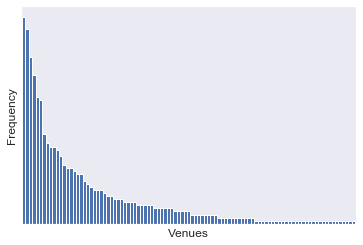

In [159]:
ax = grouped.drop(columns='neighborhood').sum().sort_values(ascending=False).plot.bar(width=1)
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('Venues')
ax.set_ylabel('Frequency')

ax.figure.savefig('./report/summary_bar.pdf', bbox_inches='tight')

## Data analysis

### Filtering results

Let's inspect the venue types to see if we should exclude any.

In [160]:
grouped.columns

Index(['neighborhood', 'African Restaurant', 'American Restaurant',
       'Asian Restaurant', 'Australian Restaurant', 'BBQ Joint', 'Bagel Shop',
       'Bakery', 'Bar', 'Bookstore', 'Breakfast Spot', 'Brewery',
       'Bubble Tea Shop', 'Buffet', 'Burger Joint', 'Burrito Place',
       'Cafeteria', 'Café', 'Cajun / Creole Restaurant',
       'Caribbean Restaurant', 'Chinese Restaurant', 'Cocktail Bar',
       'Coffee Shop', 'College Cafeteria', 'Convenience Store', 'Creperie',
       'Deli / Bodega', 'Dessert Shop', 'Dim Sum Restaurant', 'Diner',
       'Donut Shop', 'Dumpling Restaurant', 'Ethiopian Restaurant',
       'Falafel Restaurant', 'Fast Food Restaurant', 'Fish & Chips Shop',
       'Food', 'Food Court', 'Food Truck', 'French Restaurant',
       'Fried Chicken Joint', 'Frozen Yogurt Shop', 'Gastropub', 'Gay Bar',
       'Gourmet Shop', 'Greek Restaurant', 'Grocery Store', 'Halal Restaurant',
       'Historic Site', 'Hot Dog Joint', 'Hotpot Restaurant', 'Ice Cream Shop',
   

In the following, we drop bars, grocery stores, and generic venue types like "Food" and "Restaurant."

In [161]:
grouped_filtered = grouped.drop(columns=['Bar', 'Bookstore', 'Cocktail Bar', 
              'Convenience Store', 'Food', 'Food Court', 'Gay Bar', \
              'Gourmet Shop','Grocery Store', 'Historic Site', 'Karaoke Bar', \
              'Liquor Store', 'Market', 'Music Venue', 'Pet Store', \
              'Residential Building (Apartment / Condo)', 'Restaurant', \
              'Whisky Bar', 'Wine Bar'])

In [162]:
grouped_filtered.head()

neighborhood  African Restaurant  American Restaurant  Asian Restaurant  \
0      Allston                   0                    0                 0   
1     Back Bay                   0                    3                 0   
2  Bay Village                   0                    0                 0   
3  Beacon Hill                   0                    1                 0   
4     Brighton                   0                    1                 0   

   Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  Breakfast Spot  \
0                      0          0           0       1               0   
1                      0          0           0       2               1   
2                      0          0           0       0               0   
3                      0          0           0       1               1   
4                      0          0           0       0               1   

   Brewery  ...  Taco Place  Tapas Restaurant  Tea Room  Thai Restaurant  \
0        0  ...           1                 0         1                1   
1        0  ...           0                 0         0                0   
2        0  ...           0                 0         0                0   
3        0  ...           0                 0         0                1   
4        0  ...           0                 1         0                1   

   Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0                 0                   0                0   
1                 0                   0                0   
2                 0                   0                0   
3                 0                   0                0   
4                 0                   0                0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                              0                      1            0  
1                              0                      1            0  
2                              0                      0            0  
3                              0                      0            0  
4                              0                      0            0  

[5 rows x 81 columns]

This eliminated 19 types of venues.

A good "diversity" metric for comparing neighborhoods based on restaurant diversity is the following:
$$
\text{Diversity} = \frac{\text{Number of unique restaurant types}}{\text{Total number of restaurants}}.
$$
We calculate this and add it as a column to the dataframe.

In [170]:
grouped_tmp = grouped.drop(columns=['neighborhood'])
N_unique = grouped_tmp[grouped_tmp != 0].count(axis=1) # count every entry that is not zero.
N_total = grouped_tmp.sum(axis=1) # total number

try: # for rerunning cell
    grouped_filtered.drop(columns='diversity', inplace=True)
except:
    pass
    
grouped_filtered.insert(1, 'diversity', N_unique/N_total)
grouped_filtered.head()

neighborhood  diversity  African Restaurant  American Restaurant  \
0      Allston   0.650000                   0                    0   
1     Back Bay   0.609756                   0                    3   
2  Bay Village   0.666667                   0                    0   
3  Beacon Hill   0.750000                   0                    1   
4     Brighton   0.666667                   0                    1   

   Asian Restaurant  Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                 0                      0          0           0       1   
1                 0                      0          0           0       2   
2                 0                      0          0           0       0   
3                 0                      0          0           0       1   
4                 0                      0          0           0       0   

   Breakfast Spot  ...  Taco Place  Tapas Restaurant  Tea Room  \
0               0  ...           1                 0         1   
1               1  ...           0                 0         0   
2               0  ...           0                 0         0   
3               1  ...           0                 0         0   
4               1  ...           0                 1         0   

   Thai Restaurant  Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0                1                 0                   0                0   
1                0                 0                   0                0   
2                0                 0                   0                0   
3                1                 0                   0                0   
4                1                 0                   0                0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                              0                      1            0  
1                              0                      1            0  
2                              0                      0            0  
3                              0                      0            0  
4                              0                      0            0  

[5 rows x 82 columns]

Let's see the distribution of this diversity index across all neighborhoods.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D37CD198C8>]],
      dtype=object)

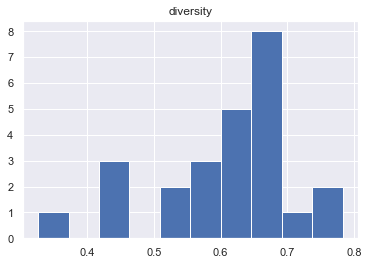

In [172]:
grouped_filtered.hist(column='diversity')

Great, so there is a broad range of neighborhoods with varying diversity, but it's not clear how to organize them. For that, we turn to clustering.

### Blind clustering

As a start, let's just blindly cluster the neighborhoods based on the frequency of each venue type. We will use the $k$-means algorithm and choose the optimal $k$ using the "elbow" method.

Text(0, 0.5, 'Sum of squared error')

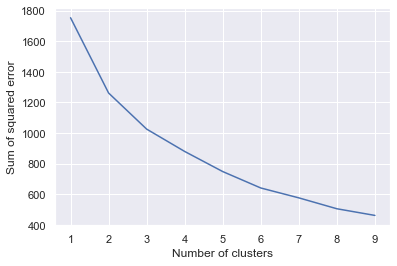

In [173]:
errors = []
ks = list(range(1,10))

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)\
                .fit(grouped_filtered.drop(columns=['neighborhood', 'diversity']))
    errors.append(kmeans.inertia_)
    
fig, ax = plt.subplots()
ax.plot(ks, errors)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Sum of squared error')

This plot shows that as the number of clusters increases, the total "distance" between data points and the cluster centers (in "venue type" space) decreases as we include more clusters. The improvement in the fit slows down at the "elbow" of the plot ($k=3$), suggesting that we should cluster the neighborhoods into three groups. Let's add the labels from the 3-cluster results to the dataframe.

In [175]:
kmeans = KMeans(n_clusters=3, random_state=0)\
         .fit(grouped_filtered.drop(columns=['neighborhood', 'diversity']))

In [178]:
grouped_filtered.insert(1, 'labels', kmeans.labels_)
grouped_filtered.head()

neighborhood  labels  diversity  African Restaurant  American Restaurant  \
0      Allston       1   0.650000                   0                    0   
1     Back Bay       1   0.609756                   0                    3   
2  Bay Village       1   0.666667                   0                    0   
3  Beacon Hill       1   0.750000                   0                    1   
4     Brighton       0   0.666667                   0                    1   

   Asian Restaurant  Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                 0                      0          0           0       1   
1                 0                      0          0           0       2   
2                 0                      0          0           0       0   
3                 0                      0          0           0       1   
4                 0                      0          0           0       0   

   ...  Taco Place  Tapas Restaurant  Tea Room  Thai Restaurant  \
0  ...           1                 0         1                1   
1  ...           0                 0         0                0   
2  ...           0                 0         0                0   
3  ...           0                 0         0                1   
4  ...           0                 1         0                1   

   Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0                 0                   0                0   
1                 0                   0                0   
2                 0                   0                0   
3                 0                   0                0   
4                 0                   0                0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                              0                      1            0  
1                              0                      1            0  
2                              0                      0            0  
3                              0                      0            0  
4                              0                      0            0  

[5 rows x 83 columns]

Let's examine the distribution of diversity metrics in each cluster.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D37CCFF888>,
      dtype=object)

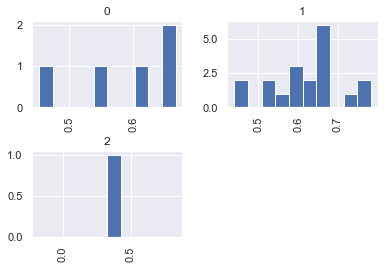

In [179]:
grouped_filtered.hist(column='diversity', by='labels')

These are clearly not the clusters we were after. We are looking to cluster neighborhood based on the level of restaurant diversity, but of course we didn't tell $k$-means this, so it must be clustering based on a different criterion. Let's examine the most common restaurant types for neighborhoods in each cluster.

In [239]:
df_top5 = pd.DataFrame() # new dataframe for the top 5 restaurant types in each neighborhood

label = 0
for i, (n, label) in enumerate(zip(grouped_filtered['neighborhood'], grouped_filtered['labels'])):
    # sort venues in each neighborhood based on frequency
    freq = grouped_filtered.iloc[i, 2:].sort_values(ascending=False)
    dict_top5 = {
        'venue type %i' %j: freq.index[j] for j in range(5)
    }
    dict_top5['neighborhood'] = n
    dict_top5['label'] = label
    df_top5 = df_top5.append(dict_top5, ignore_index=True)

df_top5 = df_top5.astype({'label': int})
df_top5

label             neighborhood             venue type 0  \
0       1                  Allston      Fried Chicken Joint   
1       1                 Back Bay              Coffee Shop   
2       1              Bay Village               Food Truck   
3       1              Beacon Hill              Pizza Place   
4       0                 Brighton              Pizza Place   
5       0              Charlestown                     Café   
6       1                Chinatown       Chinese Restaurant   
7       0               Dorchester              Pizza Place   
8       1                 Downtown              Coffee Shop   
9       1              East Boston      American Restaurant   
10      1                   Fenway              Coffee Shop   
11      1                Hyde Park              Pizza Place   
12      1            Jamaica Plain              Coffee Shop   
13      1         Leather District         Asian Restaurant   
14      0                 Longwood                     Café   
15      1                 Mattapan              Pizza Place   
16      1             Mission Hill              Pizza Place   
17      2                North End       Italian Restaurant   
18      1               Roslindale                   Bakery   
19      1                  Roxbury       African Restaurant   
20      1             South Boston  New American Restaurant   
21      1  South Boston Waterfront       Seafood Restaurant   
22      1                South End      American Restaurant   
23      0                 West End              Pizza Place   
24      1             West Roxbury     Fast Food Restaurant   

            venue type 1             venue type 2             venue type 3  \
0      Korean Restaurant              Coffee Shop     Fast Food Restaurant   
1    American Restaurant       Italian Restaurant             Burger Joint   
2     Italian Restaurant               Steakhouse           Sandwich Place   
3      French Restaurant              Coffee Shop           Sandwich Place   
4                   Café              Coffee Shop         Greek Restaurant   
5            Pizza Place            Deli / Bodega                Gastropub   
6                 Bakery          Bubble Tea Shop         Asian Restaurant   
7                   Café    Vietnamese Restaurant       Mexican Restaurant   
8     Seafood Restaurant               Donut Shop  New American Restaurant   
9     Seafood Restaurant              Coffee Shop             Burger Joint   
10       Thai Restaurant                     Café               Donut Shop   
11                Bakery      American Restaurant     Caribbean Restaurant   
12   American Restaurant  New American Restaurant                   Bakery   
13           Coffee Shop           Sandwich Place                     Café   
14           Coffee Shop           Sandwich Place               Food Truck   
15  Caribbean Restaurant     Fast Food Restaurant                   Bakery   
16            Donut Shop         Sushi Restaurant      American Restaurant   
17           Pizza Place                   Bakery                     Café   
18    Chinese Restaurant              Pizza Place     Fast Food Restaurant   
19   American Restaurant      Fried Chicken Joint     Fast Food Restaurant   
20                 Diner              Pizza Place       Italian Restaurant   
21            Steakhouse       Mexican Restaurant      American Restaurant   
22    Italian Restaurant               Donut Shop       Seafood Restaurant   
23                  Café              Coffee Shop       Mexican Restaurant   
24   American Restaurant          Thai Restaurant       Italian Restaurant   

            venue type 4  
0            Pizza Place  
1           Dessert Shop  
2              diversity  
3    American Restaurant  
4       Sushi Restaurant  
5            Coffee Shop  
6      Hotpot Restaurant  
7     Chinese Restaurant  
8   Fast Food Restaurant  
9            Pizza Place  
10    Mexican Restaurant  
11          

In [232]:
df_top5.dtypes['label'] = int